In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sn
import nbimporter
from plot_exploration import plot_scatter_tooltip
import bokeh
from bokeh.plotting import output_notebook
output_notebook()


data = pd.read_csv("data/combined_stats.csv", index_col=0)
# data = data.dropna()
# Missing column is awards_per (useless)
data = data.rename(columns={'USG%':'USG'})
relevant_players = data[(data['MP_g'] > 10) & (data['G'] > 20)]
data.head()

Loading BokehJS ...

,Rk_g,Player,Age_g,Team_g,Pos_g,G_g,GS_g,MP_g,FG_g,FGA_g,...,ORB_per,DRB_per,TRB_per,AST_per,STL_per,BLK_per,TOV_per,PF_per,PTS_per,Awards_per
0,1.0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,...,2.6,9.2,11.8,6.0,1.3,1.8,4.1,3.1,37.2,AS
1,2.0,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,...,0.8,8.1,8.9,9.4,1.4,0.5,3.9,2.0,32.5,MVP-3CPOY-6ASNBA1
2,3.0,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,...,2.7,9.0,11.8,6.7,1.2,1.1,3.5,2.9,31.2,MVP-4DPOY-9CPOY-12ASNBA1
3,4.0,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,...,0.9,4.9,5.9,6.6,2.1,0.9,2.3,2.6,31.8,MVP-2DPOY-7CPOY-3ASNBA1
4,5.0,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,...,0.6,3.1,3.7,6.9,0.9,0.2,2.5,1.9,29.2,MVP-5CPOY-5ASNBA2


## Simple correlation Analysis on Advanced Stats

In [2]:
# Including some sleepers & lower role players
adv_cols = ['Player', 'Fpoints_avg_G', 'Fpoints_avg_min', 'Fpoints_per36', 'STL%', 'BLK%', 'USG', '3PAr', 'FTr', 'TRB%', 
               'OWS', 'DWS', 'WS/48', 'BPM', 'VORP']

# adv_data = relevant_players[adv_cols]
adv_data = data[adv_cols]
print(len(adv_data))

adv_data.sort_values(by = 'Fpoints_avg_min', ascending = False).head(50).reset_index(drop=True, inplace=True)
adv_data['Fpoints_permin_rank'] = adv_data['Fpoints_avg_min'].rank(ascending=False)
adv_data['Fpoints_pergame_rank'] = adv_data['Fpoints_avg_G'].rank(ascending=False)
adv_data['permin_pergame_rank_diff'] = adv_data['Fpoints_permin_rank'] - adv_data['Fpoints_pergame_rank']
# adv_data.sort_values(by='permin_pergame_rank_diff', ascending=False).head(30)
adv_data.sort_values(by = 'Fpoints_pergame_rank')[['Player', 'Fpoints_pergame_rank', 'Fpoints_permin_rank']]
print(len(adv_data))

adv_data.to_csv("data/all_players_with_ranks.csv")


572
572


/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_44460/2487116344.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adv_data['Fpoints_permin_rank'] = adv_data['Fpoints_avg_min'].rank(ascending=False)
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_44460/2487116344.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adv_data['Fpoints_pergame_rank'] = adv_data['Fpoints_avg_G'].rank(ascending=False)
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_44460/2487116344.py:12: Sett

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_44460/2333302274.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(adv_data.corr(), annot=True, vmin = -1, vmax = 1)


<Figure size 3000x3000 with 0 Axes>

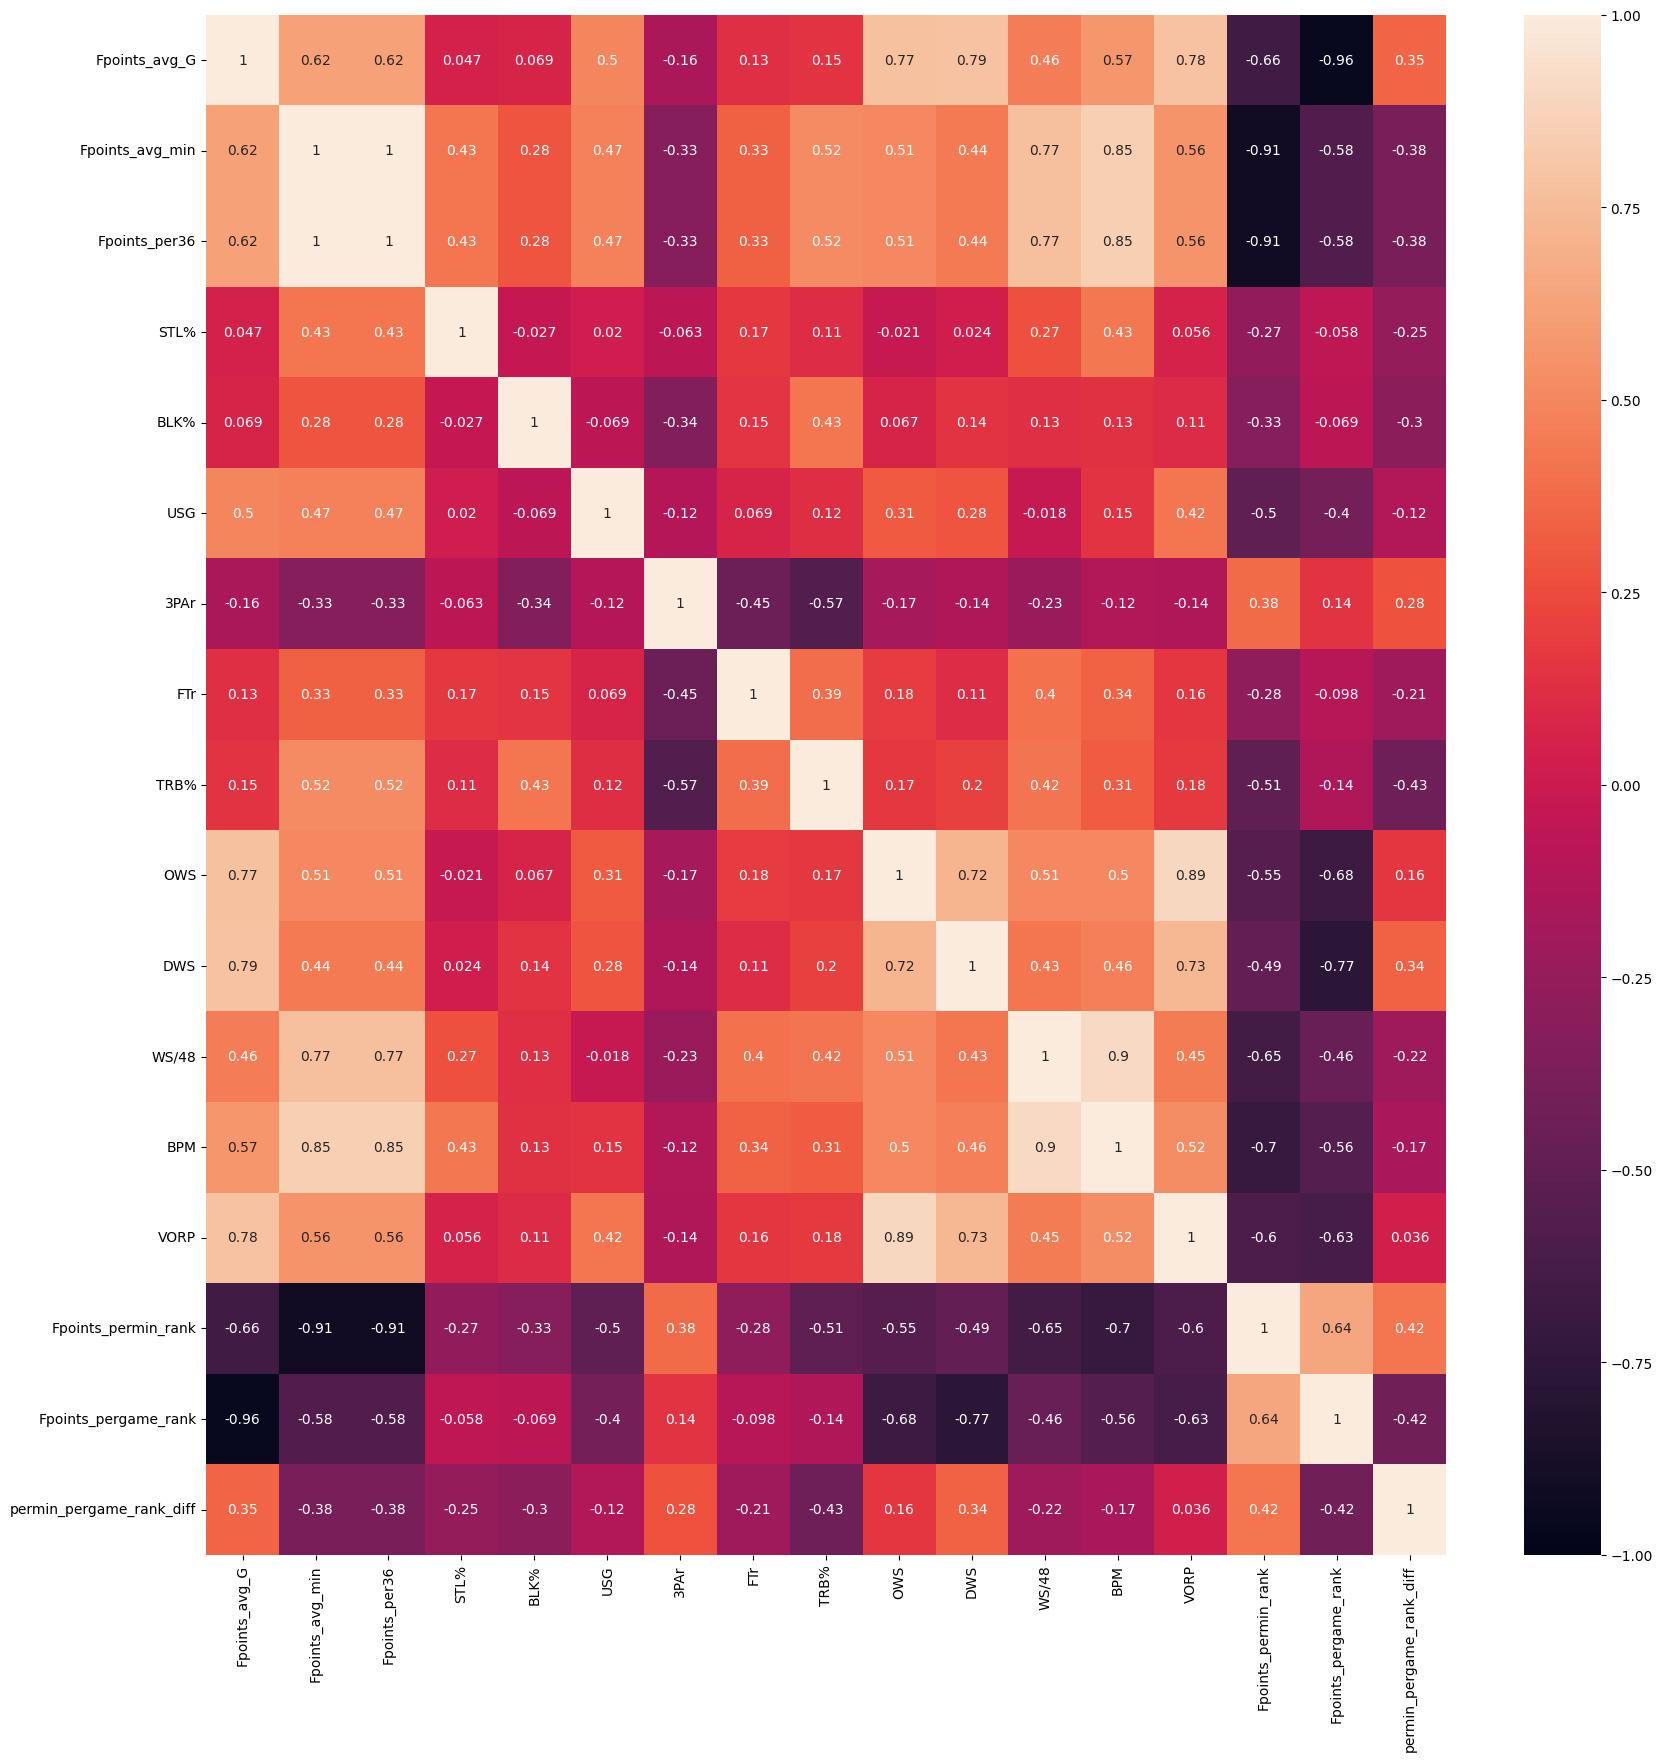

<Figure size 3000x3000 with 0 Axes>

In [3]:
plt.figure(figsize=(20,20))
sn.heatmap(adv_data.corr(), annot=True, vmin = -1, vmax = 1)
plt.figure(figsize=(30,30))

### Random Forest Model on Advanced Stats 
Model created not to predict - but to extract feature importances and find another measure of how what advanced stats relate strongly to fantasy points per minute. 

Mean Squared Error: 0.019706501938432885
   Feature  Importance
9      BPM    0.562637
10    VORP    0.201140
8    WS/48    0.110820
2      USG    0.048760
4      FTr    0.016753
3     3PAr    0.015831
1     BLK%    0.013745
5     TRB%    0.012771
6      OWS    0.008229
0     STL%    0.005144
7      DWS    0.004171


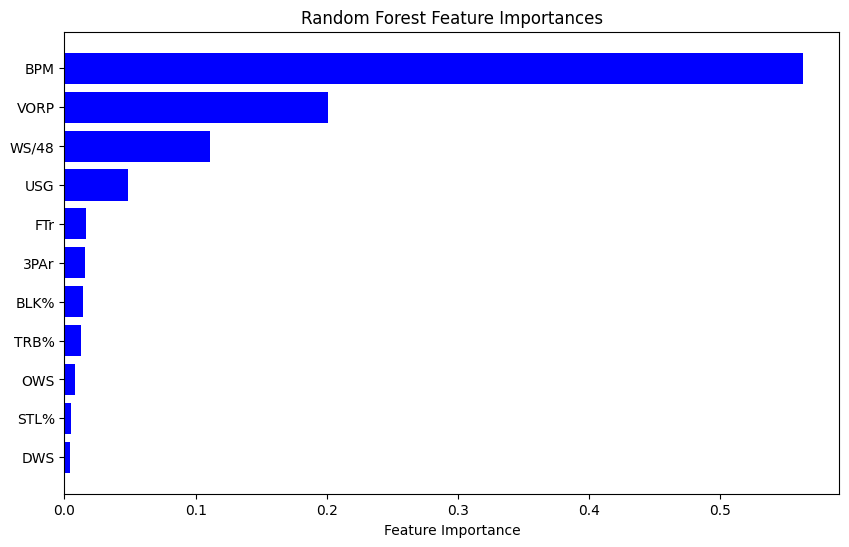

<Figure size 640x480 with 0 Axes>

In [5]:
adv_cols = ['Fpoints_avg_min', 'STL%', 'BLK%', 'USG', '3PAr', 'FTr', 'TRB%', 
            'OWS', 'DWS', 'WS/48', 'BPM', 'VORP']
data=data.dropna()
# Define X (features) and y (target variable)
X = data[adv_cols].drop(columns=['Fpoints_avg_min'])
y = data['Fpoints_avg_min']

# Train-test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Extract and plot feature importances
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()
plt.savefig("plots/rfimp.png")

In [6]:
# Plotting fpoints per min rank vs BPM to try and find outliers
plot_scatter_tooltip(adv_data, "Fpoints_permin_rank", "BPM")